In [82]:
import rasterio
import fiona
import numpy as np
from rasterio import features
from affine import Affine
from shapely.geometry import shape, box
import geopandas as gpd
import rioxarray
import xarray as xr
from shapely.ops import unary_union


def _rasterize_geom(geom, shape, affinetrans, all_touched):
    indata = [(geom, 1)]
    rv_array = features.rasterize(
        indata,
        out_shape=shape,
        transform=affinetrans,
        fill=0,
        all_touched=all_touched)
    return rv_array


def rasterize_pctcover(geom, atrans, shape):
    alltouched = _rasterize_geom(geom, shape, atrans, all_touched=True)
    exterior = _rasterize_geom(geom.exterior, shape, atrans, all_touched=True)

    # Create percent cover grid as the difference between them
    # at this point all cells are known 100% coverage,
    # we'll update this array for exterior points
    pctcover = (alltouched - exterior) * 100

    # loop through indicies of all exterior cells
    for r, c in zip(*np.where(exterior == 1)):

        # Find cell bounds, from rasterio DatasetReader.window_bounds
        window = ((r, r+1), (c, c+1))
        ((row_min, row_max), (col_min, col_max)) = window
        x_min, y_min = (col_min, row_max) * atrans
        x_max, y_max = (col_max, row_min) * atrans
        bounds = (x_min, y_min, x_max, y_max)

        # Construct shapely geometry of cell
        cell = box(*bounds)

        # Intersect with original shape
        cell_overlap = cell.intersection(geom)

        # update pctcover with percentage based on area proportion
        coverage = cell_overlap.area / cell.area
        pctcover[r, c] = int(coverage * 100)

    return pctcover


if __name__ == "__main__":


    # Path to the GeoTIFF file
    file_path_raster = "/Users/wcurrier/Desktop/livneh_CRB_mask.tif"
    
    xds = rioxarray.open_rasterio(file_path_raster)
    lat_min=xds.y.min()
    lat_max=xds.y.max()
    lon_min=xds.x.min()
    lon_max=xds.x.max()
    
    gdf=gpd.read_file('/Users/wcurrier/Desktop/huc4/WBD_HUC4_XCONUS.gpkg')
    gdf_sub=gdf.cx[lon_min:lon_max,lat_min:lat_max]
    
    # Loop through rows using isel
    for i in range(len(gdf_sub)):
        # Use isel to select rows by index position
        selected_row = gdf_sub.iloc[i]
        print(selected_row['name'])
        # Access the geometry column
        geom = selected_row['geometry']
    
        # Check if it's a MultiPolygon
        if isinstance(geom, MultiPolygon):
            print("It's a MultiPolygon.")
            geom = unary_union(geom)            

        try:
            # Open the GeoTIFF file
            with rasterio.open(file_path_raster) as dataset:
                # Get the affine transformation matrix
                atrans = dataset.transform
                profile = dataset.profile
                shape = dataset.shape

            pctcover = rasterize_pctcover(geom, atrans=atrans, shape=shape)
            pctcover = pctcover/100
            with rasterio.open('/Users/wcurrier/Desktop/huc4/rasters/'+selected_row['name'].replace(" ", "_")+'_percent_cover.tif', 'w', **profile) as dst:
                dst.write(pctcover, 1)
                
        except:
            print('failed on: '+selected_row['name'])

/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Lower Pecos
It's a MultiPolygon.


/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Right multiplication will be prohibited in version 3.0
/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Right multiplication will be prohibited in version 3.0


Nueces-Southwestern Texas Coastal
It's a MultiPolygon.
Central California Coastal
It's a MultiPolygon.
failed on: Central California Coastal
Southern California Coastal
It's a MultiPolygon.
failed on: Southern California Coastal
Northern Mojave-Mono Lake
It's a MultiPolygon.
San Francisco Bay
It's a MultiPolygon.
failed on: San Francisco Bay
Southern Mojave-Salton Sea
It's a MultiPolygon.
Sacramento
It's a MultiPolygon.
North Lahontan
It's a MultiPolygon.
Upper Columbia
It's a MultiPolygon.
Puget Sound
It's a MultiPolygon.
Souris
It's a MultiPolygon.
Milk
It's a MultiPolygon.
Yakima
It's a MultiPolygon.
Lower Green
It's a MultiPolygon.
Minnesota
It's a MultiPolygon.
Rio Conchos
It's a MultiPolygon.
Rio Salado
It's a MultiPolygon.
Rio Grande-Amistad
It's a MultiPolygon.
Rio Grande-Falcon
It's a MultiPolygon.
Lower Snake
It's a MultiPolygon.
Middle Snake
It's a MultiPolygon.
Arkansas-Keystone
It's a MultiPolygon.
Neosho-Verdigris
It's a MultiPolygon.
Black Rock Desert-Humboldt
It's a Mul

In [3]:
import rasterio
import fiona
import numpy as np
from rasterio import features
from affine import Affine
from shapely.geometry import shape, box
import geopandas as gpd
import rioxarray
import xarray as xr
from shapely.ops import unary_union

# Path to the GeoTIFF file
file_path_raster = "/Users/wcurrier/Desktop/livneh_CRB_mask.tif"

xds = rioxarray.open_rasterio(file_path_raster)
lat_min=xds.y.min()
lat_max=xds.y.max()
lon_min=xds.x.min()
lon_max=xds.x.max()

gdf=gpd.read_file('/Users/wcurrier/Desktop/huc4/WBD_HUC4_XCONUS.gpkg')
gdf_sub=gdf.cx[lon_min:lon_max,lat_min:lat_max]
    
matrices = []

for i in range(len(gdf_sub)):
    try:
        # Use isel to select rows by index position
        selected_row = gdf_sub.iloc[i]
#         print(selected_row['name'])
        xds = rioxarray.open_rasterio('/Users/wcurrier/Desktop/huc4/rasters/'+selected_row['name'].replace(" ", "_")+'_percent_cover.tif')
        # Append the matrix to the list
        matrices.append(xds.drop('band').drop('spatial_ref'))
    except:
        print('failed')
        
# Stack the matrices along a new dimension (e.g., watershed name)
stacked_data = xr.concat(matrices, dim='watershed')
stacked_data

/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


failed
failed
failed
failed


<xarray.DataArray (watershed: 97, band: 1, y: 400, x: 448)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
...
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * y        (y) float64 52.97 52.91 52.84 52.78 ... 28.22 28.16 28.09 28.03
  * x        (x) float64 -125.0 -124.9 -124.8 -124.8 ... -97.16 -97.09 -97.03
Dimensions without coordinates: watershed, band
Attributes:
    _FillValue:    9.969209968386869e+36
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [6]:
# Import state vector file using geopandas
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

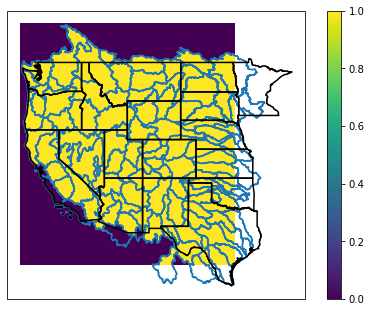

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax=plt.axes((0,0,1,1),projection=ccrs.PlateCarree())
stacked_data.sum(dim='watershed').plot()
gdf_sub.boundary.plot(ax=ax)
states_gdf.cx[lon_min:lon_max,lat_min:lat_max].boundary.plot(ax=ax,color='black')